In [1]:
# from google.colab import drive 
# drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [1]:
# Cloning the repo to use files

!git clone https://github.com/kishkath/ERA.git

Cloning into 'ERA'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 26 (delta 1), reused 26 (delta 1), pack-reused 0
Receiving objects: 100% (26/26), 338.23 KiB | 3.32 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
# pre-loaded python library imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os 

os.chdir("/kaggle/working/ERA/5 - PyTorch/")

# Custom defined class imports
from model import Net 
from utils import Plots,Load_dataset

In [3]:
from numpy import e
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda == True:
  device = "cuda"
else:
  device = "cpu"

CUDA Available? True


In [4]:
# load_data
# set BATCH_SIZE
BATCH_SIZE = 512 
train_loader,test_loader = Load_dataset(BATCH_SIZE).get_dataset()
print(len(train_loader),len(test_loader))

100%|██████████| 9912422/9912422 [00:00<00:00, 102803555.83it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 69738453.55it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26560558.70it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12759898.71it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

118 20


<Figure size 640x480 with 0 Axes>

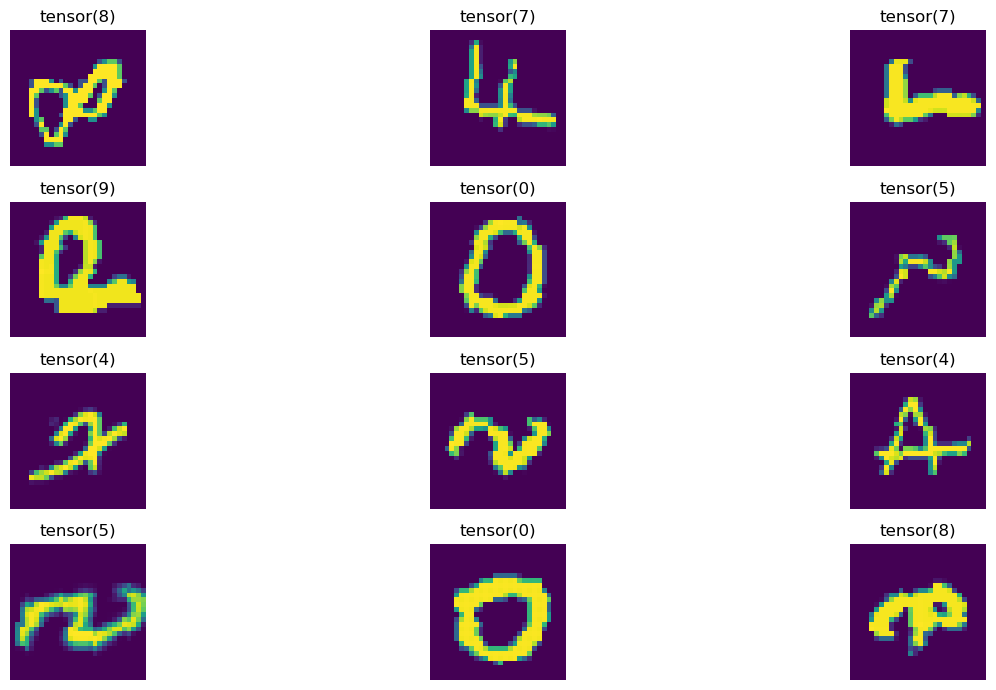

In [5]:
# Lets see few images, provide number of images needed also a multiple of 3.
plot_imgs = Plots(num_images=12,loaded_data=train_loader)
plot_imgs.plot_images()

<Figure size 640x480 with 0 Axes>

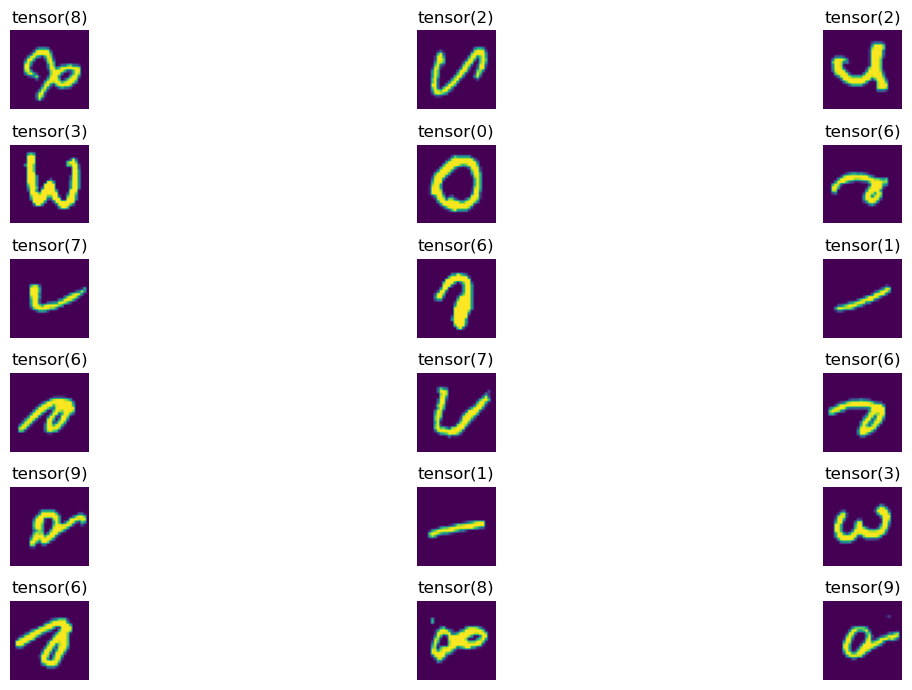

In [6]:
# Lets see few images
plot_imgs = Plots(num_images=19,loaded_data=test_loader)
plot_imgs.plot_images()

In [8]:
!pip install torchsummary
from torchsummary import summary
model = Net().to(device)
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [9]:
## Storing metrics
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [11]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     
     


In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=1.5757 Batch_id=117 Accuracy=29.51: 100%|██████████| 118/118 [00:19<00:00,  6.08it/s]


Test set: Average loss: 0.0031, Accuracy: 4211/10000 (42.11%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1501 Batch_id=117 Accuracy=86.57: 100%|██████████| 118/118 [00:19<00:00,  6.21it/s]


Test set: Average loss: 0.0003, Accuracy: 9589/10000 (95.89%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0738 Batch_id=117 Accuracy=95.31: 100%|██████████| 118/118 [00:19<00:00,  5.90it/s]


Test set: Average loss: 0.0002, Accuracy: 9759/10000 (97.59%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0581 Batch_id=117 Accuracy=96.50: 100%|██████████| 118/118 [00:20<00:00,  5.89it/s]


Test set: Average loss: 0.0002, Accuracy: 9753/10000 (97.53%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0791 Batch_id=117 Accuracy=97.06: 100%|██████████| 118/118 [00:19<00:00,  6.13it/s]


Test set: Average loss: 0.0001, Accuracy: 9813/10000 (98.13%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 6


Train: Loss=0.0195 Batch_id=117 Accuracy=97.71: 100%|██████████| 118/118 [00:19<00:00,  5.95it/s]


Test set: Average loss: 0.0001, Accuracy: 9850/10000 (98.50%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 7


Train: Loss=0.0682 Batch_id=117 Accuracy=97.80: 100%|██████████| 118/118 [00:20<00:00,  5.88it/s]


Test set: Average loss: 0.0001, Accuracy: 9867/10000 (98.67%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 8


Train: Loss=0.0403 Batch_id=117 Accuracy=97.83: 100%|██████████| 118/118 [00:19<00:00,  6.13it/s]


Test set: Average loss: 0.0001, Accuracy: 9867/10000 (98.67%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 9


Train: Loss=0.0133 Batch_id=117 Accuracy=97.84: 100%|██████████| 118/118 [00:20<00:00,  5.84it/s]


Test set: Average loss: 0.0001, Accuracy: 9864/10000 (98.64%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 10


Train: Loss=0.0370 Batch_id=117 Accuracy=97.89: 100%|██████████| 118/118 [00:19<00:00,  5.99it/s]


Test set: Average loss: 0.0001, Accuracy: 9866/10000 (98.66%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 11


Train: Loss=0.0397 Batch_id=117 Accuracy=97.93: 100%|██████████| 118/118 [00:18<00:00,  6.28it/s]


Test set: Average loss: 0.0001, Accuracy: 9869/10000 (98.69%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 12


Train: Loss=0.0442 Batch_id=117 Accuracy=97.98: 100%|██████████| 118/118 [00:19<00:00,  6.20it/s]


Test set: Average loss: 0.0001, Accuracy: 9869/10000 (98.69%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 13


Train: Loss=0.0568 Batch_id=117 Accuracy=97.94: 100%|██████████| 118/118 [00:20<00:00,  5.78it/s]


Test set: Average loss: 0.0001, Accuracy: 9868/10000 (98.68%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 14


Train: Loss=0.0717 Batch_id=117 Accuracy=98.00: 100%|██████████| 118/118 [00:19<00:00,  6.00it/s]


Test set: Average loss: 0.0001, Accuracy: 9872/10000 (98.72%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 15


Train: Loss=0.0653 Batch_id=117 Accuracy=97.94: 100%|██████████| 118/118 [00:19<00:00,  6.13it/s]


Test set: Average loss: 0.0001, Accuracy: 9872/10000 (98.72%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 16


Train: Loss=0.0934 Batch_id=117 Accuracy=97.97: 100%|██████████| 118/118 [00:20<00:00,  5.86it/s]


Test set: Average loss: 0.0001, Accuracy: 9872/10000 (98.72%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 17


Train: Loss=0.0168 Batch_id=117 Accuracy=97.98: 100%|██████████| 118/118 [00:19<00:00,  6.01it/s]


Test set: Average loss: 0.0001, Accuracy: 9872/10000 (98.72%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 18


Train: Loss=0.0113 Batch_id=117 Accuracy=97.97: 100%|██████████| 118/118 [00:19<00:00,  5.98it/s]


Test set: Average loss: 0.0001, Accuracy: 9872/10000 (98.72%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 19


Train: Loss=0.2194 Batch_id=117 Accuracy=97.99: 100%|██████████| 118/118 [00:20<00:00,  5.89it/s]


Test set: Average loss: 0.0001, Accuracy: 9872/10000 (98.72%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 20


Train: Loss=0.0889 Batch_id=117 Accuracy=97.95: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


Test set: Average loss: 0.0001, Accuracy: 9872/10000 (98.72%)

Adjusting learning rate of group 0 to 1.0000e-06.


None


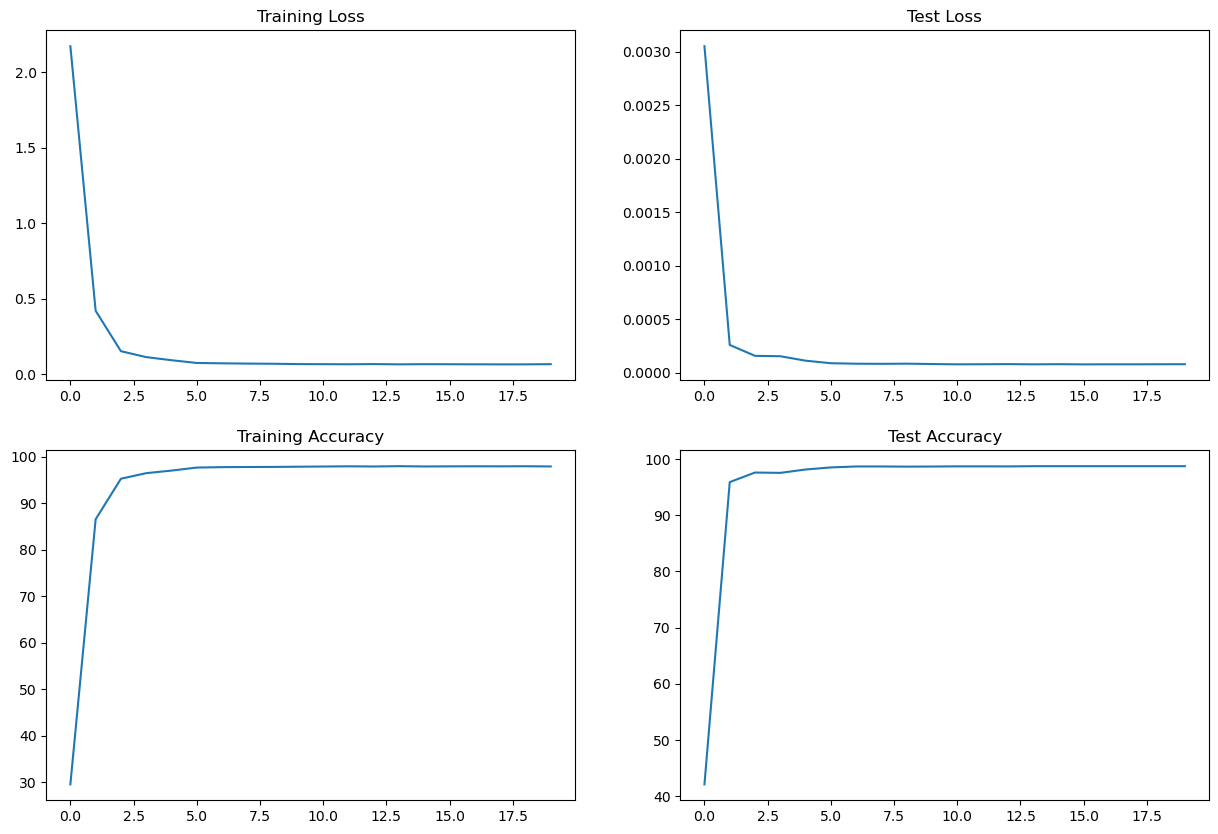

In [13]:
plot_acc = Plots(None,None,metrics=[train_losses,train_acc,test_losses,test_acc])
print(plot_acc.plot_metrics())

In [14]:
print("Done!")

Done!
